# Offline plotting with categorical data

This notebook is a collection of plotting examples using the `plot_dataset` function and caterogical (string-valued) data. The notebook should cover all possible permutations of categorical versus numerical data.

In [1]:
%matplotlib inline
from pathlib import Path

import numpy as np

from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.parameters import Parameter

In [2]:
initialise_or_create_database_at(
    Path.cwd().parent / "example_output" / "offline_plotting_example_categorical.db"
)
exp = load_or_create_experiment("offline_plotting_experiment", "nosample")

## 1D plotting

### Category is the independent parameter

With the category as the independent parameter, `plot_dataset` will default to a bar plot as long as there is
at most one value per category. If more than one value is found for any category a bar plot is not possible, and the `plot_dataset` falls back to a scatter plot.

In [3]:
voltage = Parameter("voltage", label="Voltage", unit="V", set_cmd=None, get_cmd=None)
fridge_config = Parameter(
    "config", label="Fridge configuration", set_cmd=None, get_cmd=None
)

meas = Measurement(exp=exp)
meas.register_parameter(fridge_config, paramtype="text")
meas.register_parameter(voltage, setpoints=(fridge_config,))

with meas.run() as datasaver:
    configurations = ["open", "outer chamber closed", "pumping", "closed"]

    for configuration in configurations:
        datasaver.add_result(
            (fridge_config, configuration), (voltage, np.random.rand())
        )

dataset = datasaver.dataset

Starting experimental run with id: 1. 


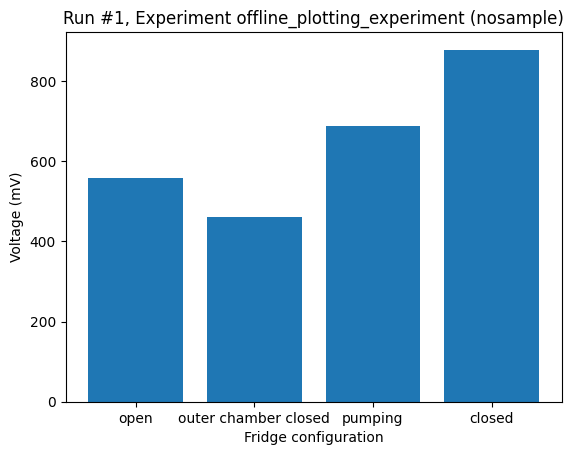

In [4]:
_ = plot_dataset(dataset)

Starting experimental run with id: 2. 


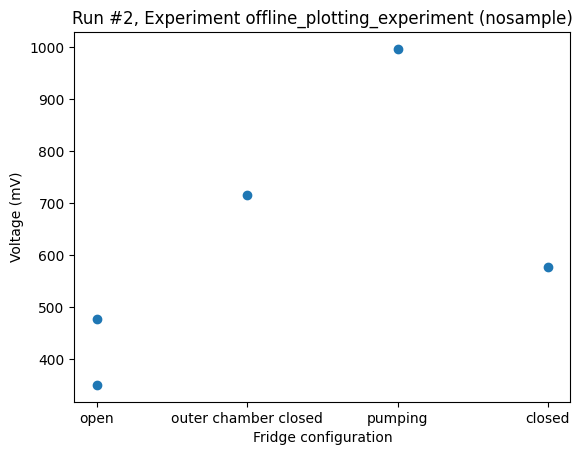

In [5]:
with meas.run() as datasaver:
    configurations = ["open", "outer chamber closed", "pumping", "closed"]

    for configuration in configurations:
        datasaver.add_result(
            (fridge_config, configuration), (voltage, np.random.rand())
        )

    datasaver.add_result((fridge_config, "open"), (voltage, np.random.rand()))

dataset = datasaver.dataset

_ = plot_dataset(dataset)

### Category is the dependent parameter

With the categories as the dependent variable, i.e., the _outcome_ of a measurement, the `plot_dataset` defaults to a scatter plot.

Here is an example with made-up parameters and random values.

**UNRESOLVED**: How do we ensure the y-axis order?


In [6]:
voltage = Parameter("voltage", label="Voltage", unit="V", set_cmd=None, get_cmd=None)
response = Parameter("response", label="Sample response", set_cmd=None, get_cmd=None)

meas = Measurement(exp=exp)
meas.register_parameter(voltage)
meas.register_parameter(response, paramtype="text", setpoints=(voltage,))


with meas.run() as datasaver:
    for volt in np.linspace(0, 1, 50):
        coinvalue = volt + 0.5 * np.random.randn()
        if coinvalue < 0:
            resp = "Bad"
        elif coinvalue < 0.8:
            resp = "Good"
        else:
            resp = "Excellent"

        datasaver.add_result((voltage, volt), (response, resp))

dataset = datasaver.dataset

Starting experimental run with id: 3. 


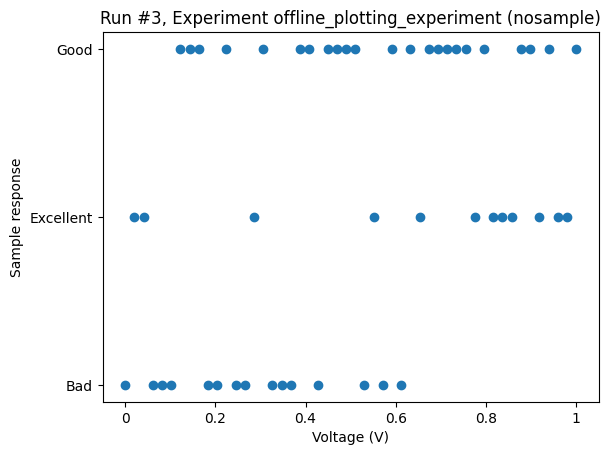

In [7]:
_ = plot_dataset(dataset)

## Both variables are categorical

For both variables being categorical, the `plot_dataset` defaults to a scatter plot.

This case would typically be some summary of a large number of measurements.

In [8]:
sample = Parameter("sample", label="Sample", unit="", set_cmd=None, get_cmd=None)
feature = Parameter("feature", label="Physical feature", set_cmd=None, get_cmd=None)

meas = Measurement(exp=exp)
meas.register_parameter(sample, paramtype="text")
meas.register_parameter(feature, paramtype="text", setpoints=(sample,))


with meas.run() as datasaver:
    features = ["superconducting", "qubit", "clean states", "high bandwidth"]

    for samp in ["Nanowire", "Silicon Chip", "SQUID", "Membrane"]:
        feats = np.random.randint(1, 5)
        for _ in range(feats):
            datasaver.add_result(
                (sample, samp), (feature, features[np.random.randint(0, 4)])
            )

dataset = datasaver.dataset

Starting experimental run with id: 4. 


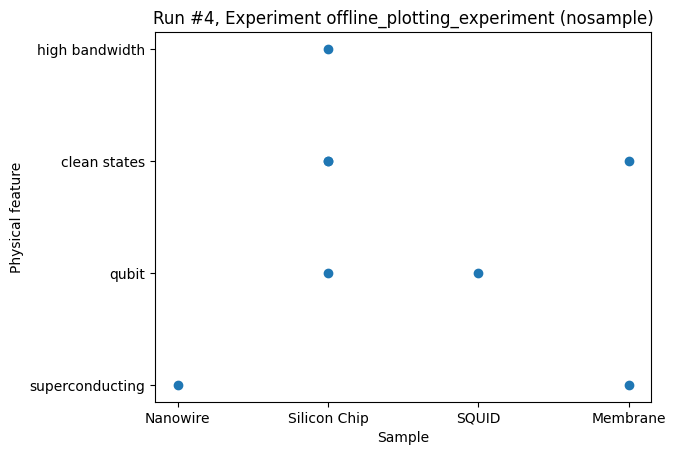

In [9]:
_ = plot_dataset(dataset)

## 2D plotting

Naming convention: the x-axis is horizontal, the y-axis is vertical, and the z-axis is out-of-plane.

### Categorical data on the x-axis

Here is an example where different samples are tested for conductivity. The longer the name of the sample, the higher the conductivity.

In [10]:
sample = Parameter("sample", label="Sample", unit="", set_cmd=None, get_cmd=None)
gate_voltage = Parameter(
    "gate_v", label="Gate voltage", unit="V", set_cmd=None, get_cmd=None
)
conductance = Parameter(
    "conductance", label="Conductance", unit="e^2/hbar", set_cmd=None, get_cmd=None
)

meas = Measurement(exp=exp)
meas.register_parameter(sample, paramtype="text")
meas.register_parameter(gate_voltage)
meas.register_parameter(conductance, setpoints=(sample, gate_voltage))


with meas.run() as datasaver:
    for samp in ["Nanowire", "Silicon Chip", "SQUID", "Membrane"]:
        gate_vs = np.linspace(0, 0.075, 75)

        for gate_v in gate_vs:
            datasaver.add_result(
                (sample, samp),
                (gate_voltage, gate_v),
                (conductance, len(samp) * gate_v),
            )

dataset = datasaver.dataset

Starting experimental run with id: 5. 


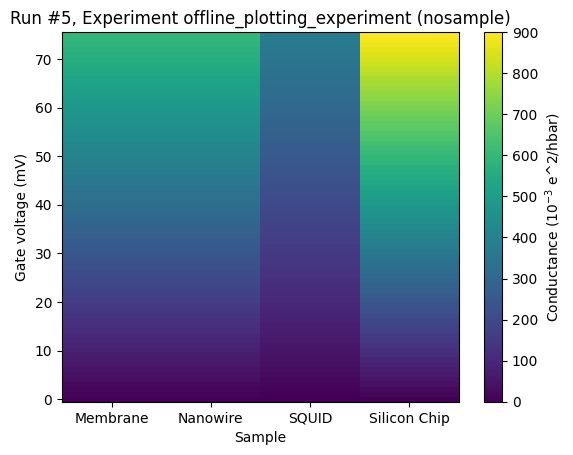

In [11]:
ax, _ = plot_dataset(dataset)

### Categorical data on the y-axis

This situation is very similar to having categorical data on the x-axis. We reuse the same example.

In [12]:
sample = Parameter("sample", label="Sample", unit="", set_cmd=None, get_cmd=None)
gate_voltage = Parameter(
    "gate_v", label="Gate voltage", unit="V", set_cmd=None, get_cmd=None
)
conductance = Parameter(
    "conductance", label="Conductance", unit="e^2/hbar", set_cmd=None, get_cmd=None
)

meas = Measurement(exp=exp)
meas.register_parameter(sample, paramtype="text")
meas.register_parameter(gate_voltage)
meas.register_parameter(conductance, setpoints=(gate_voltage, sample))


with meas.run() as datasaver:
    for samp in ["Nanowire", "Silicon Chip", "SQUID", "Membrane"]:
        gate_vs = np.linspace(0, 0.01, 75)

        for gate_v in gate_vs:
            datasaver.add_result(
                (sample, samp),
                (gate_voltage, gate_v),
                (conductance, len(samp) * gate_v),
            )

dataset = datasaver.dataset

Starting experimental run with id: 6. 


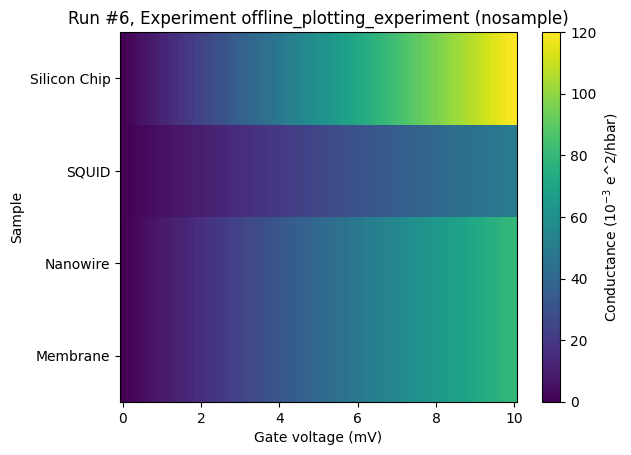

In [13]:
ax, _ = plot_dataset(dataset)

### Categorical data on the z-axis

Categorical data on the z-axis behaves similarly to numerical data on the z-axis; what kind of plot we get depends on the structure of the setpoints (i.e. the x-axis and y-axis data). If the setpoints are on a grid, we get a heatmap. If not, we get a scatter plot.

#### Gridded setpoints

In [14]:
bias_voltage = Parameter(
    "bias_v", label="Bias voltage", unit="V", set_cmd=None, get_cmd=None
)
gate_voltage = Parameter(
    "gate_v", label="Gate voltage", unit="V", set_cmd=None, get_cmd=None
)
useful = Parameter(
    "usefulness", label="Usefulness of region", set_cmd=None, get_cmd=None
)

meas = Measurement(exp=exp)
meas.register_parameter(gate_voltage)
meas.register_parameter(bias_voltage)
meas.register_parameter(
    useful, setpoints=(bias_voltage, gate_voltage), paramtype="text"
)


# a function to simulate the usefulness of a region


def get_usefulness(x, y):
    val = np.sin(x) * np.sin(y)
    if val < -0.4:
        return "Useless"
    if val < 0:
        return "Bad"
    if val < 0.5:
        return "Possible"
    return "Good"


with meas.run() as datasaver:
    for bias_v in np.linspace(0, 3, 100):
        for gate_v in np.linspace(-1, 1, 75):
            datasaver.add_result(
                (bias_voltage, bias_v),
                (gate_voltage, gate_v),
                (useful, get_usefulness(bias_v, gate_v)),
            )

dataset = datasaver.dataset

Starting experimental run with id: 7. 


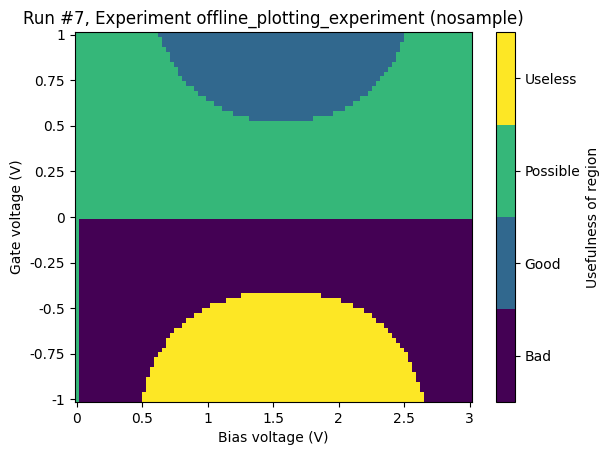

In [15]:
ax, cax = plot_dataset(dataset)

#### Scattered setpoints

The same example as above, but this time with setpoints not on a grid.

In [16]:
bias_voltage = Parameter(
    "bias_v", label="Bias voltage", unit="V", set_cmd=None, get_cmd=None
)
gate_voltage = Parameter(
    "gate_v", label="Gate voltage", unit="V", set_cmd=None, get_cmd=None
)
useful = Parameter(
    "usefulness", label="Usefulness of region", set_cmd=None, get_cmd=None
)

meas = Measurement(exp=exp)
meas.register_parameter(gate_voltage)
meas.register_parameter(bias_voltage)
meas.register_parameter(
    useful, setpoints=(bias_voltage, gate_voltage), paramtype="text"
)


# a function to simulate the usefulness of a region


def get_usefulness(x, y):
    val = np.sin(x) * np.sin(y)
    if val < -0.4:
        return "Useless"
    if val < 0:
        return "Bad"
    if val < 0.5:
        return "Possible"
    return "Good"


with meas.run() as datasaver:
    for bias_v in 3 * (np.random.rand(100)):
        for gate_v in 2 * (np.random.rand(75) - 0.5):
            datasaver.add_result(
                (bias_voltage, bias_v),
                (gate_voltage, gate_v),
                (useful, get_usefulness(bias_v, gate_v)),
            )

dataset = datasaver.dataset

Starting experimental run with id: 8. 


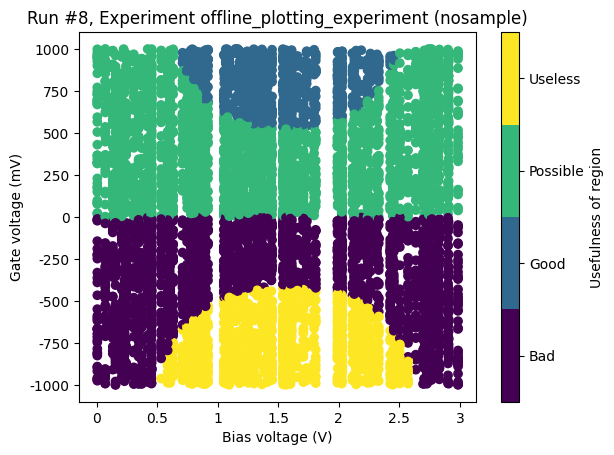

In [17]:
ax, cax = plot_dataset(dataset)

### Categorical data on x-axis and z-axis

For completeness, we include two examples of this situation. One resulting in a grid and one resulting in a scatter plot. We reuse the example with the x- and  y-axes having numerical data with just a slight modification.

In [18]:
sample = Parameter("sample", label="Sample", set_cmd=None, get_cmd=None)
gate_voltage = Parameter(
    "gate_v", label="Gate voltage", unit="V", set_cmd=None, get_cmd=None
)
useful = Parameter(
    "usefulness", label="Usefulness of region", set_cmd=None, get_cmd=None
)

meas = Measurement(exp=exp)
meas.register_parameter(sample, paramtype="text")
meas.register_parameter(gate_voltage)
meas.register_parameter(useful, setpoints=(sample, gate_voltage), paramtype="text")

samples = ["nanowire", "2DEG", "spin qubit", "nanowire_alt"]

# a function to simulate the usefulness of a region


def get_usefulness(x, y):
    x_num = samples.index(x) * 4 / len(samples)
    val = np.sin(x_num) * np.sin(y)
    if val < -0.4:
        return "Useless"
    if val < 0:
        return "Bad"
    if val < 0.5:
        return "Possible"
    return "Good"


with meas.run() as datasaver:
    for samp in samples:
        for gate_v in np.linspace(-1, 1, 75):
            datasaver.add_result(
                (sample, samp),
                (gate_voltage, gate_v),
                (useful, get_usefulness(samp, gate_v)),
            )

dataset = datasaver.dataset

Starting experimental run with id: 9. 


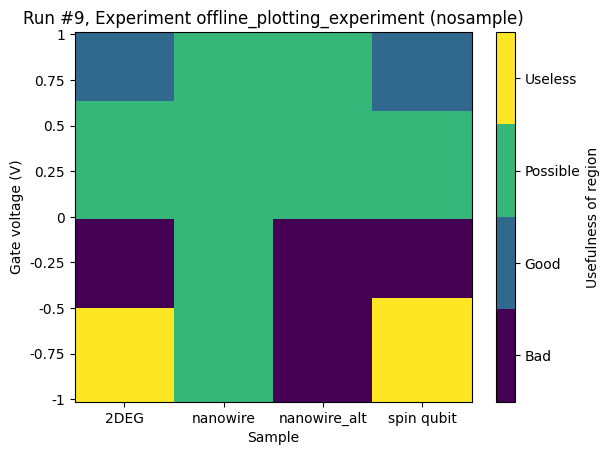

In [19]:
ax, cax = plot_dataset(dataset)

In [20]:
sample = Parameter("sample", label="Sample", set_cmd=None, get_cmd=None)
gate_voltage = Parameter(
    "gate_v", label="Gate voltage", unit="V", set_cmd=None, get_cmd=None
)
useful = Parameter(
    "usefulness", label="Usefulness of region", set_cmd=None, get_cmd=None
)

meas = Measurement(exp=exp)
meas.register_parameter(sample, paramtype="text")
meas.register_parameter(gate_voltage)
meas.register_parameter(useful, setpoints=(sample, gate_voltage), paramtype="text")

samples = ["nanowire", "2DEG", "spin qubit", "nanowire_alt"]

# a function to simulate the usefulness of a region


def get_usefulness(x, y):
    x_num = samples.index(x) * 4 / len(samples)
    val = np.sin(x_num) * np.sin(y)
    if val < -0.4:
        return "Useless"
    if val < 0:
        return "Bad"
    if val < 0.5:
        return "Possible"
    return "Good"


with meas.run() as datasaver:
    for samp in samples:
        for gate_v in 2 * (np.random.rand(75) - 0.5):
            datasaver.add_result(
                (sample, samp),
                (gate_voltage, gate_v),
                (useful, get_usefulness(samp, gate_v)),
            )

dataset = datasaver.dataset

Starting experimental run with id: 10. 


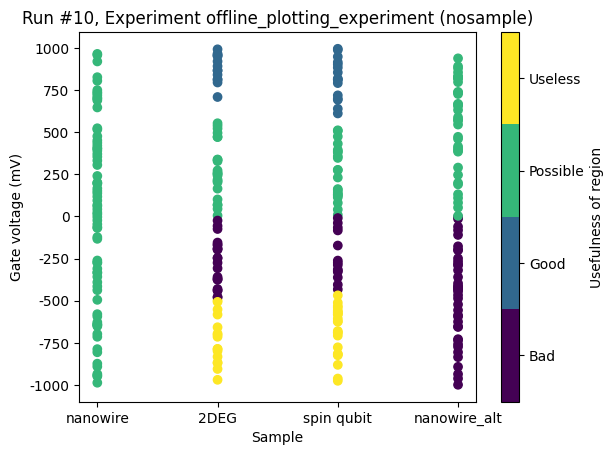

In [21]:
ax, cax = plot_dataset(dataset)